## Lysozyme in Water
* https://openmm.github.io/openmm-cookbook/latest/notebooks/tutorials/protein_in_water.html
* Based on http://www.mdtutorials.com/gmx/lysozyme/index.html
### TOC
* Load a PDB file into OpenMM
* Choose the force-field
* Clean-up the file
* Solvate the protein with water and ions
* Setup system and integrator
* Run local minization
* Run NVT equilibration
* Run NPT production molecular dynamics
* Basic analysis

### Download the PDB file, and load PDB

In [39]:
# !wget https://files.rcsb.org/download/1AKI.pdb -O ./data/1AKI.pdb

In [40]:
# Load the PDB file
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

pdb = PDBFile("./data/1AKI.pdb")

In [41]:
import nglview as nv
view = nv.show_structure_file("./data/1AKI.pdb")
view.add_representation('cartoon', selection='protein')
view.add_representation('licorice', selection='water')
view

NGLWidget()

In [42]:
# Define the force field
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

In [43]:
# Clean up the PDB file
# This PDB file contains some crystal water molecules which we want to strip out. 
# This can be done using the Modeller class. 
# We also add in any missing H atoms.
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()
residues=modeller.addHydrogens(forcefield)

In [44]:
# We can use the addSolvent method to add water molecules
# This command creates a box that has edges at least 1nm away from the solute 
# and fills it with water molecules. 
# is it enough to add 1nm or should we add more?
modeller.addSolvent(forcefield, padding=1*nanometer)

In [45]:
with open('./results/1aki_clean.pdb', 'w') as f:
    PDBFile.writeFile(modeller.topology, modeller.positions, f)

In [46]:
view = nv.show_structure_file('./results/1aki_clean.pdb')
view.add_representation('cartoon', selection='protein')
view.add_representation('licorice', selection='water')
view



NGLWidget()

In [47]:
# Create the system, integrator
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [48]:
# local energy minimization
# It is a good idea to run local energy minimization at the start of a simulation, 
# since the coordinates in the PDB file might produce very large forces
print('Minimizing...')
simulation.minimizeEnergy()

Minimizing...


In [49]:
# Setup the simulation reporting
simulation.reporters.append(PDBReporter('./results/output.pdb', 1000))
# write the coordinates to a PDB file every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))
# write the energy, temperature and volume to stdout every 1000 steps in screen
simulation.reporters.append(StateDataReporter("./results/md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))
# write the energy, temperature and volume to a file every 100 steps (for later analysis)

In [50]:
# NVT equillibration
# We are using a Langevin integrator which means we are simulating in the NVT ensemble. 
# To equilibrate the temperature we just need to run the simulation for a number of timesteps.
print('Equilibrating NVT...')
simulation.step(10000)

Equilibrating NVT...
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-361418.62222535955,290.7268178030985,237.98045607433852
2000,-358813.24136598455,299.1417568616915,237.98045607433852
3000,-358391.97085817205,301.8506064073739,237.98045607433852
4000,-358433.21695192205,300.3076792420742,237.98045607433852
5000,-358118.04605348455,301.02996601254483,237.98045607433852
6000,-358035.32437379705,299.7711017083371,237.98045607433852
7000,-358704.23355348455,303.7202711474338,237.98045607433852
8000,-359029.51187379705,301.42645532235724,237.98045607433852
9000,-359294.32437379705,298.5289681373855,237.98045607433852
10000,-358721.53726442205,301.0773069752018,237.98045607433852


In [51]:
# NPT production MD
# To run our simulation in the NPT ensemble,
# we need to add in a barostat to control the pressure. 
# We can use MonteCarloBarostat.
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation.context.reinitialize(preserveState=True)


print("Running NPT")
simulation.step(10000)

Running NPT
11000,-359768.10963430605,307.8356932900488,230.1882624262468
12000,-361779.7533137067,296.99657098563557,226.5196600551854
13000,-361461.91510755196,297.94493249992314,225.18864666602255
14000,-361332.80361373187,301.4158388015206,224.5353926830094
15000,-360250.27372181555,302.47220650538867,224.60451668683993
16000,-361102.3109612246,302.34883778185474,224.21144725942128
17000,-360819.32122910954,300.28156491701634,223.68355806499497
18000,-361070.6165734404,300.9071037477688,223.65500764336952
19000,-360461.8897525149,299.9746230637053,224.9368591960569
20000,-360874.2149718136,299.50509499415216,225.6466465423234


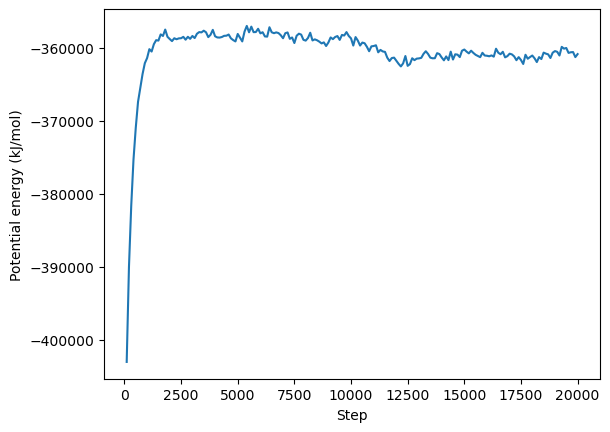

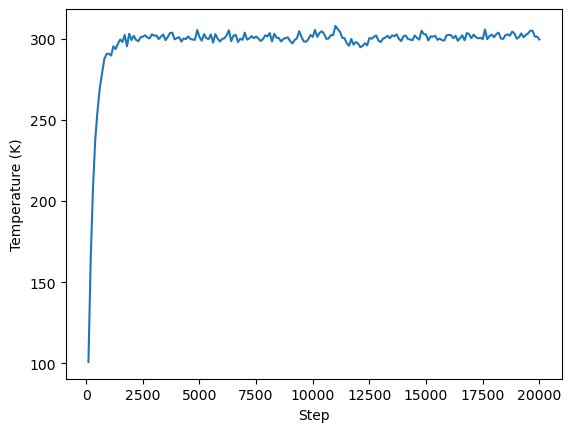

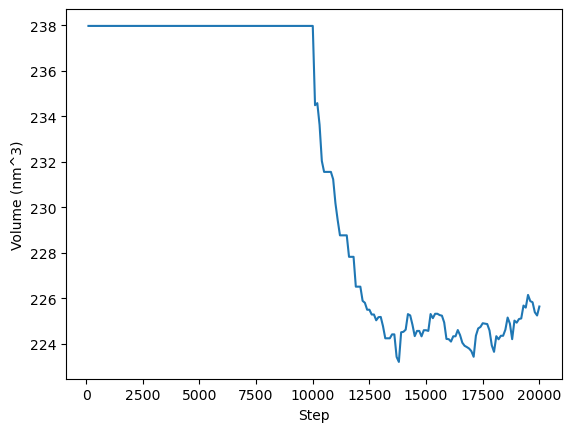

In [54]:
# Analyzing the results
# Remember that OpenMM itself is primarly an MD engine, 
# for in-depth anaylsis of your simulations 
# you can use other python packages such as MDtraj, or MDAnalysis.
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt("./results/md_log.txt", delimiter=',')

step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

plt.plot(step, potential_energy)
plt.xlabel("Step")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()
plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.show()
plt.plot(step, volume)
plt.xlabel("Step")
plt.ylabel("Volume (nm^3)")
plt.show()